In [ ]:
!nvidia-smi

Wed Jun 26 23:28:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd {HOME}
Input ='/content/drive/MyDrive/videotrackandcount.mp4'

/content


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videotrackandcount.mp4"

## Install YOLOv8

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/78.2 GB disk)


## Install ByteTrack


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!unzip '/content/drive/MyDrive/capstoneRunWithYolo1.zip' -d /content/unzipped_files


Archive:  /content/drive/MyDrive/capstoneRunWithYolo1.zip
   creating: /content/unzipped_files/content/runs/
   creating: /content/unzipped_files/content/runs/detect/
   creating: /content/unzipped_files/content/runs/detect/train/
  inflating: /content/unzipped_files/content/runs/detect/train/train_batch2.jpg  
  inflating: /content/unzipped_files/content/runs/detect/train/val_batch1_pred.jpg  
  inflating: /content/unzipped_files/content/runs/detect/train/val_batch1_labels.jpg  
  inflating: /content/unzipped_files/content/runs/detect/train/train_batch2960.jpg  
  inflating: /content/unzipped_files/content/runs/detect/train/R_curve.png  
  inflating: /content/unzipped_files/content/runs/detect/train/train_batch2962.jpg  
  inflating: /content/unzipped_files/content/runs/detect/train/results.png  
  inflating: /content/unzipped_files/content/runs/detect/train/P_curve.png  
  inflating: /content/unzipped_files/content/runs/detect/train/PR_curve.png  
  inflating: /content/unzipped_files

In [ ]:
# settings
MODEL = "/content/unzipped_files/content/runs/detect/train2/weights/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8x.pt conf=0.5 source={SOURCE_VIDEO_PATH}

/content
100% 131M/131M [00:00<00:00, 395MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 445, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 242, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 205, in predict_cli
    for _ in gen:  # running CLI inference without accumulating any outputs (do not modify)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 35, in g

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - people
CLASS_ID = [0]


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 384x640 4 peoples, 215.6ms
Speed: 14.3ms preprocess, 215.6ms inference, 1293.0ms postprocess per image at shape (1, 3, 384, 640)


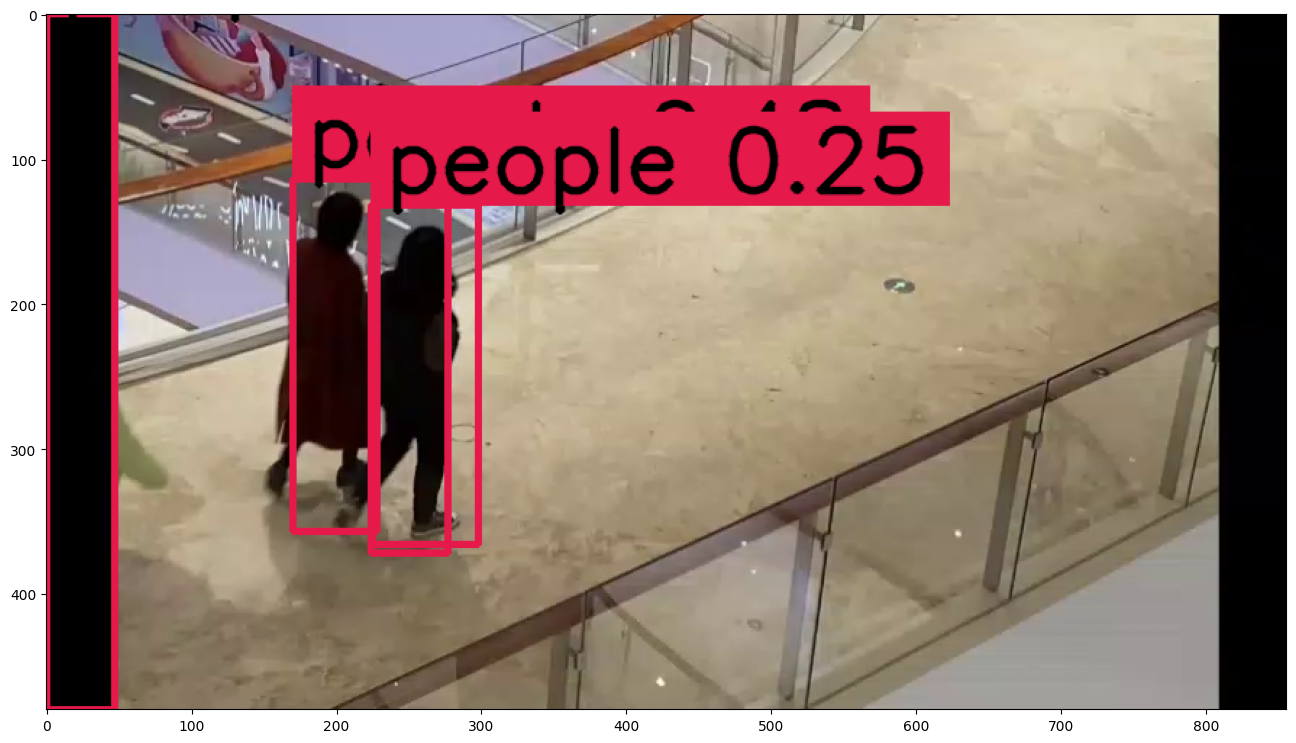

In [ ]:
# Update SOURCE_VIDEO_PATH to include the mounted drive path
SOURCE_VIDEO_PATH = '/content/drive/MyDrive/videotrackandcount.mp4'

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))